# 인공지능으로 가위 바위 보 이미지 판독기 만들기!

가위 바위 보 이미지 데이터로 인공지능을 학습시키고 각 이미지를 인식하여 알아볼 수 있는 인공지능을 구현해보고자 한다. 완성도를 판가름하기 위한 필요최소조건은 아래와 같다. 

1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
3. 분류모델의 test accuracy가 60% 이상 나왔는가?

이번 인공지능 모델을 구현하며 거쳐갈 과정은 아래와 같다. 

1. 데이터 준비 
2. 인공지능 모델 구현
3. 인공지능 모델 학습
4. 모델 평가

이 과정을 모두 거쳤던 첫 시도때에 Accuracy는 대략 33% 정도로 모델 구현이 무의미한 수치가 나왔다. 따라서 이번 과정에서는 필요최소조건을 충족시키고 모델의 예측 정확도를 더욱 개선하기 위해 두번째 시도에서 개선하고 보완할 점을 정리해 보았다. 


1. 더욱 많은 데이터 준비
 - 데이터의 수가 지나치게 적고 요소가 편향된 데이터(내가 직접 촬영한 손 이미지만 데이터로 활용했었음)라 데이터로서의 가치가 떨어지는 문제가 있었다. 
 

2. 데이터의 해상도 상향 
 - 지난번 Resizing한 데이터는 28x28 px img로 해상도가 너무 낮아 특징을 잡기 어려운 문제가 있었다.
 
 
3. 데이터를 Train set, Validation Set, Test set으로 분리하여 세밀한 모델 평가 및 검증
 - 이미 학습한 데이터를 잘 예측하는것은 소용이 없으므로 검증에 필요한 데이터는 Train set과 철저히 분리하여 평가

개선을 시작해보자.

## 데이터 준비

지난번 첫 시도에선 Teachable machine 사이트에서 제공하는 이미지 촬영 툴을 이용해 가위 바위 보 이미지 각 100장을 제작하였었다.<br>
툴에서 제공되는 기본 이미지 사이즈는 224x224 px size이고 원활한 학습을 위해 데이터를 전처리 하는 과정에서 28x28사이즈로 Resizing을 하여 진행하였었는데 이번에는 정확도를 높이기 위해 데이터의 해상도를 대폭 상향하여 112x112 px size로 Resizing하고 데이터의 수도 각 1500장 정도로 양을 대폭 늘렸다. 또한 나의 손을 촬영한 이미지만 활용한 것이 아닌 다른 Aiffel 구성원들의 손을 촬영한 이미지도 각 1400장 정도 추가 수집하여 전체 데이터에 구성에 포함시켰다. 



## 필요한 Library import

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

## 데이터 Resizing 

데이터의 사이즈를 224x224 => 112x112로 Resizing 한다.

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 112x112 사이즈로 바꾸어 저장합니다.
	target_size=(112,112)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")

In [3]:
# 가위, 바위, 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 resize
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_2nd/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_2nd/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_2nd/paper"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")
print("바위 이미지 resize 완료!")
print("보 이미지 resize 완료!")

1459  images to be resized.
1502  images to be resized.
1444  images to be resized.
가위 이미지 resize 완료!
바위 이미지 resize 완료!
보 이미지 resize 완료!


## 데이터 labeling 및 행렬 생성

In [4]:
def load_data(img_path, number_of_data=4405):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=112
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

## 데이터 정규화

In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_2nd"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 4405 입니다.
x_train shape: (4405, 112, 112, 3)
y_train shape: (4405,)


## 학습, 검증, 테스트 셋으로 데이터 분리

In [6]:
def train_val_test_split(ds, ds_size, sd,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정
        ds_shuffled = np.random.RandomState(seed=sd).permutation(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds_shuffled[0:train_size]    
    val_ds = ds_shuffled[train_size:train_size+val_size]
    test_ds = ds_shuffled[train_size+val_size:]
    
    return train_ds, val_ds, test_ds

In [7]:
x_train, x_val, x_test = train_val_test_split(x_train,4405,42)
y_train, y_val, y_test = train_val_test_split(y_train,4405,42)

## 분리된 img data set확인

In [8]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(3524, 112, 112, 3)
(440, 112, 112, 3)
(441, 112, 112, 3)


## 분리된 labeling data set 확인

In [9]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3524,)
(440,)
(441,)


## img data와 labeling 육안으로 확인

라벨:  1


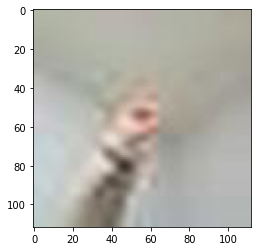

In [10]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

라벨:  0


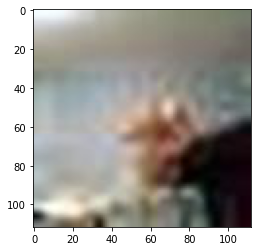

In [11]:
plt.imshow(x_train[1])
print('라벨: ', y_train[1])

라벨:  0


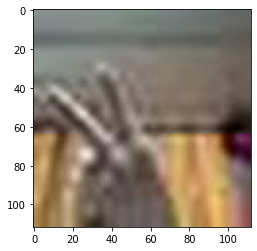

In [12]:
plt.imshow(x_train[2])
print('라벨: ', y_train[2])

라벨:  2


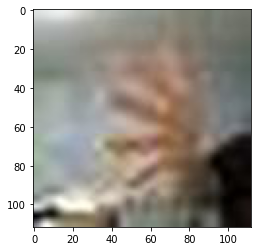

In [13]:
plt.imshow(x_train[5])
print('라벨: ', y_train[5])

## Hyper parameter 조정

In [14]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(112,112,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1384576   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

## 모델 학습

In [16]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Epoch 1/10
111/111 [==============================] - 3s 6ms/step - loss: 48.5102 - accuracy: 0.5763
Epoch 2/10
111/111 [==============================] - 1s 5ms/step - loss: 0.3099 - accuracy: 0.8851
Epoch 3/10
111/111 [==============================] - 1s 5ms/step - loss: 0.1524 - accuracy: 0.9458
Epoch 4/10
111/111 [==============================] - 1s 5ms/step - loss: 0.0694 - accuracy: 0.9779
Epoch 5/10
111/111 [==============================] - 1s 5ms/step - loss: 0.0308 - accuracy: 0.9929
Epoch 6/10
111/111 [==============================] - 1s 5ms/step - loss: 0.0218 - accuracy: 0.9969
Epoch 7/10
111/111 [==============================] - 1s 5ms/step - loss: 0.0190 - accuracy: 0.9966
Epoch 8/10
111/111 [==============================] - 1s 5ms/step - loss: 0.1199 - accuracy: 0.9552
Epoch 9/10
111/111 [==============================] - 1s 5ms/step - loss: 0.0344 - accuracy: 0.9912
Epoch 10/10
111/111 [==============================] - 1s 5ms/step - loss: 0.0107 - accuracy: 0.998

## Validation set으로 모델 성능 검증

In [17]:
test_loss, test_accuracy = model.evaluate(x_val, y_val, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

14/14 - 0s - loss: 0.0720 - accuracy: 0.9818
test_loss : 0.07195746153593063
test_accuracy : 0.9818181991577148


## Test set으로 모델 성능 평가

In [18]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 2)

print("최종 test_loss : {}".format(test_loss))
print("최종 test_accuracy : {}".format(test_accuracy))

14/14 - 0s - loss: 0.0285 - accuracy: 0.9909
최종 test_loss : 0.028493570163846016
최종 test_accuracy : 0.9909297227859497


## 모델이 잘못 예측한 데이터 육안으로 확인

예측확률분포: [0.24764831 0.02167633 0.73067534]
라벨: 0, 예측결과: 2


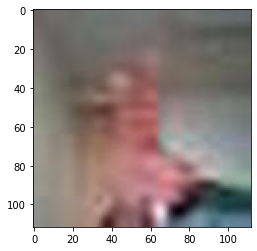

예측확률분포: [3.8703984e-06 5.1321417e-02 9.4867474e-01]
라벨: 1, 예측결과: 2


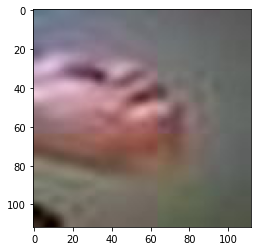

예측확률분포: [0.07236304 0.12173326 0.8059037 ]
라벨: 1, 예측결과: 2


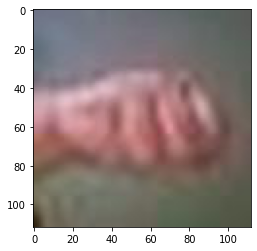

예측확률분포: [0.07236304 0.12173326 0.8059037 ]
라벨: 1, 예측결과: 2


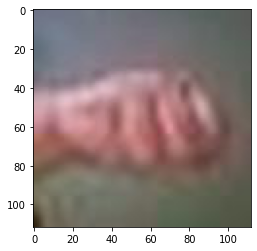

예측확률분포: [0.0256373  0.8740432  0.10031956]
라벨: 2, 예측결과: 1


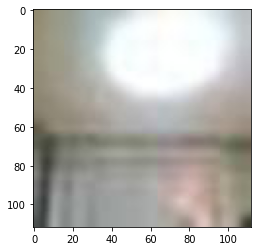

In [19]:
predicted_result = model.predict(x_test)  
predicted_labels = np.argmax(predicted_result, axis=1)

import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

## 결론

#### Validation set에서 모델의 예측 성능은 98.18%를 기록<br><br>Test set에서 모델의 예측 성능은 최종적으로 99.09%을 기록

## 후기

이번 가위바위보 판독기를 구현함으로 인해 처음 인공지능에 대해 배운 여러 용어와 개념을 잘 정리하게된 계기가 되었다. 또한 여러가지 시행착오와 이를 극복하는 과정속에서 각각의 코드와 데이터가 어떻게 상호작용하고 연결되는지 탐구해 볼 수 있었다. 인공지능 모델의 예측 정확도를 개선하는 과정에서 양질의 데이터의 중요성을 체감하게 되었으며, 모델이 좋은 결과를 내기 위해선 데이터가 해결하려는 문제에 적절한 방법으로 학습되어지고 있는지에 대해서도 깊이 생각해야 할 필요성을 절감하였다.

예측 성능을 1%라도 쥐어짜내어 최대한 끌어올리기 위해 신경썼던 부분은 데이터의 수집과 전처리 뿐만 아니라 Hyper Parameter의 최적화된 값을 찾아내기 위해 여러번 실험을 반복하였던 점이다. 다만 이 부분은 추후 모델을 학습시키는 연구자의 직감 의존하는 것이 아닌 해결하고자 하는 문제에 대한 근거를 갖추어 Hyper parameter 값을 최적화 시킬 수 있다면 더욱 좋겠다고 생각하였다. 이러한 점은 내가 추후 학습을 통해 보완하여야 할 여러 개선점 중 하나가 될 것이다. 

모델이 구현되는 모든 과정을 거치며 구체적으로 모델의 작동 원리와 코드의 상호작용을 깊이 이해한것은 아니지만 정말 많은 개념과 이론의 실재를 확인할 수 있었고 학습과 실습에 대한 여러 개선점도 남긴 소중한 프로젝트였다. 